<h1> DAY 2: Approximate Reinforcement Learning </h1>
<p> <img src="http://skyai.org/wiki/?plugin=attach&refer=Documentation%2FTutorial%20-%20Example%20-%20Mountain%20Car&openfile=mountaincar.png" alt="picture of the mountain-car environment" style="float:right;width:500px;border:10px solid #FFFFFF;">
<h3> MountainCar </h3>
<p> A car starts in a valley between two mountains, as depicted in the image to the right. The car must reach the goal location on the top of the right mountain by using three possible actions: accelerate forwards, backwards or doing nothing. However, the car's motor is underactuated and cannot drive straight uphill. The agent's task is to find a policy that swings the car back and forth such that it eventually reaches the goal position. </p>
<p> The state space contains the continuous position of the car in [-1.2, 0.6] and its continuous velocity in [-0.07, 0.07]. The reward is 0 for reaching the goal and -1 for each other step. Episodes end after reaching the goal or 1000 steps otherwise (this is a deviation from the classical task). </p>
</p>

# EXERCISE 1: Tabular Q-learning
In this exercise, you will familiarise yourself with a given agent class and an experiment script that runs OpenAI Gym environments.

In the following code block, we define a longer Mountain-Car environment from the OpenAI Gym.
Note that some installed libraries may throw some warnings here. Ignore them unless task 1c does not work.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import gym
import torch
#import torch.nn as nn
#import torch.nn.functional as F
import random
from math import e as nate

def make_environment():
    """ Returns a new mountain-car environment. """
    # Register special version of MountainCar with long episodes
    gym.envs.register(
        id='MountainCarExtraLong-v0',
        entry_point='gym.envs.classic_control:MountainCarEnv',
        max_episode_steps=1000,
        reward_threshold=-110.0,
    )
    # Create environment
    env = gym.make('MountainCarExtraLong-v0')
    env_name = 'MountainCarExtraLong-v0'
    env = gym.make(env_name)
    # Set seeds (for reproduceability)
    env.seed(0)
    np.random.seed(0)
    torch.manual_seed(0)
    return env

# Make a mountain-car environment
env = make_environment()

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/Users/gorceixantoine/opt/anaconda3/envs/rl_day2/lib/python3.9/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/gorceixantoine/opt/anaconda3/envs/rl_day2/lib/python3.9/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the defau

## TASK 1a: the agent
Familiarise yourself with the below specification of a QLearner at the example of the following Tabular Q-Learner.
Given the action to execute, gym environments return the next state, the received reward and a Boolean done, which indicated that the episode has ended.

Complete the update() function of the TabularQLearner by filling in the TD-error for Q-learning. Make sure that the value of the next state is 0 for the last step of an episode, that is, when done=True.

Timeout stuff.

In [2]:
class QLearner:
    """ Specifies a RL agent that can compute Q-values. """
    gamma = 0.9    # discount factor
    name = None    # the name of this agent (for the legend in plots)
    epsilon = 0.1  # the exploration parameter for epsilon-greedy

    def q_values(self, state):
        """ Returns the estimated Q-values (as a np.ndarray) of the given state. """
        assert False, "Abstract class must be inherited from to get Q-values."

    def sample(self, state):
        """ Returns a greedily sampled action according to the estimated Q-values of the given state. """
        assert False, "Abstract class must be inherited from to sample."

    def update(self, state, action, reward, next_state, done):
        """ Updates the Q-value estimate after observing a transition from 'state', using 'action',
            receiving 'reward' and ending up in 'next_state'. The Boolean 'done' indicates whether
            or not the episode has ended with this transition. Returns nothing. """
        assert False, "Abstract class must be inherited from to update."

    def get_epsilon(self):
        """ Returns the exploration parameter of epsilon-greedy. """
        return self.epsilon

    def set_epsilon(self, iter):
        """ Can be overwritten to change the exploration parameter during training. """
        pass


class TabularQLearner (QLearner):
    """ Tabular Q-learning agent. """
    learn_rate = 0.1    # learning rate of the Q-learning update
    n_states = 40       # number of states per state-dimension
    q_table = None      # table with Q-values
    env_low = None
    env_dx = None

    def __init__(self, env, n_states=None):
        """ Creates a tabular Q-learning agent with n_states in each of teh env(ironments) state directions. """
        self.name = "Tabular (%u states)" % (n_states ** 2)
        if n_states is not None:
            self.n_states = n_states
        self.env_low = env.observation_space.low
        self.env_dx = (env.observation_space.high - self.env_low) / (self.n_states - 1)
        self.q_table = np.zeros((self.n_states, self.n_states, env.action_space.n))

    def _state_to_index(self, obs):
        """ Maps an observed state to an index of the q_table. """
        a = int((obs[0] - self.env_low[0]) / self.env_dx[0])
        b = int((obs[1] - self.env_low[1]) / self.env_dx[1])
        return a, b

    def q_values(self, state):
        """ Returns the estimated Q-values (as a np.ndarray) of the given state. """
        a, b = self._state_to_index(state)
        return self.q_table[a][b]

    def sample(self, state):
        """ Returns a greedily sampled action according to the estimated Q-values of the given state. """
        return np.argmax(self.q_values(state))

    def update(self, state, action, reward, next_state, done):
        """ The agent 'learns' from the given transition. """
        not_done = 0 if done else 1
        a, b = self._state_to_index(state)
        a_, b_ = self._state_to_index(next_state)
        # Update Q-table with the TD-error for Q-learning (fill in to complete class)
        td_error = reward +  self.gamma*self.q_table[a_][b_][self.sample(next_state)]*not_done-self.q_table[a][b][action]
        self.q_table[a][b][action] = self.q_table[a][b][action] + self.learn_rate * td_error

The following code-block contains a plotting function that keeps track of the experimental results. Re-executing this block, or calling clear_plots(), will clear all previous experiments from future plots; otherwise the specifics of the code block can be ignored (but has to be exectuted) for the exercise.

In [ ]:
def clear_plots():
    """ Clears the plot buffers from previous experimental results"""
    global last_agent, plot_rewards, plot_labels
    last_agent = None
    plot_rewards = []
    plot_labels = []

def compute_q_values(env):
    """ Computes the Q-values on an equidistant grid. """
    dim = 100    # resolution of the resulting image
    env_low = env.observation_space.low
    env_high = env.observation_space.high
    # Create the states
    states = np.zeros((2, dim ** 2))
    states[0, :] = np.tile(np.linspace(env_low[0], env_high[0], num=dim), dim)
    states[1, :] = np.repeat(np.linspace(env_high[1], env_low[1], num=dim), dim)
    q_values = np.zeros((3, dim ** 2))
    for i in range(dim ** 2):
        q = last_agent.q_values(states[:, i])
        q_values[:, i] = q.detach().cpu().numpy() if isinstance(q, torch.Tensor) else q
    return q_values

def compute_trajectory(env, agent):
    """ Returns a trajectory (as np.ndarray) in the given env(ironment) executed by the given agent. """
    env_low = env.observation_space.low
    env_high = env.observation_space.high
    state = env.reset()
    traj = [(state - env_low) / (env_high - env_low)]
    done = False
    while(not done):
        action = agent.sample(state)
        state, _, done, _ = env.step(action)
        traj.append((state - env_low) / (env_high - env_low))
    return np.stack(traj, axis=1)

def plot_as_image(ax, env, values):
    """ Plots a given np.ndarray of values as a sqare image in the given ax(es). """
    dim = int(np.sqrt(len(values)))
    env_low = env.observation_space.low
    env_high = env.observation_space.high
    cax = ax.imshow(values.reshape((dim, dim)), extent=[0, 1, 0, 1], cmap='jet')
    ax.set_xlabel('Car Position')
    ax.set_xticklabels(["%g" % (env_low[0] + i * (env_high[0] - env_low[0]) / 5) for i in range(6)])
    ax.set_ylabel('Car Velocity')
    ax.set_yticklabels(["%g" % (env_low[1] + i * (env_high[1] - env_low[1]) / 5) for i in range(6)])
    return plt.gcf().colorbar(cax, ax=ax)

def plot_all_results(env, plot_std=True):
    """ Plots the performance of all experiments in the result-buffers, as well as the value function/policy
        of the agent at the end of the last experiment. """
    colors = ['orange', 'red', 'magenta', 'blue', 'green', 'black', 'c', 'y', 'lime']
    # Generate figure and subplot grid
    gs = matplotlib.gridspec.GridSpec(2, 5)
    ax1 = plt.subplot(gs[:, :3])
    ax2 = plt.subplot(gs[0, 3:])
    ax3 = plt.subplot(gs[1, 3:])
    plt.gcf().set_size_inches([16, 7.5])
    # Plot the performance
    if plot_std:
        # Make a nice plot with mean and standard deviation for every 10 samples
        for i in range(len(plot_rewards)):
            rew = np.array(plot_rewards[i])
            n = len(rew)
            if n < 10:
                # fallback: plot raw if not enough points
                x = np.arange(1, n+1)
                ax1.plot(x, rew, color=colors[i % len(colors)], label=plot_labels[i])
                continue
            reshaped = rew[:(n - n % 10)].reshape(int((n - n % 10) / 10), 10)
            m = np.mean(reshaped, axis=1)
            s = np.std(reshaped, axis=1)
            x = np.linspace(5, 10 * len(m) + 5, len(m))
            ax1.fill_between(x=x, y1=m - s, y2=m + s, alpha=0.2, linewidth=0, facecolor=colors[i % len(colors)])
            ax1.plot(x, m, color=colors[i % len(colors)], label=plot_labels[i])
        ax1.set_xlabel("Environmental Steps")
        ax1.set_ylabel("Episode Reward (STD)")
        ax1.set_ylim(-1000, 0)
        # set_xlim to match plotted x-range if possible
        try:
            ax1.set_xlim(0, x[-1] + 5)
        except:
            pass
    else:
        # Use an ugly plot that plots every single measurement
        for i, rewards in enumerate(plot_rewards):
            ax1.plot(rewards, color=colors[i % len(colors)], label=plot_labels[i])
        ax1.set_xlabel("Epsiodes")
        ax1.set_ylabel("Episode Reward")
    ax1.legend(loc='lower right')
    # Generate Q-values and example trajectories
    traj_list = [compute_trajectory(env, last_agent) for _ in range(3)]
    traj_colors = ['darkgrey', 'lightgrey', 'white']
    q_values = compute_q_values(env)
    # Plot the value function
    plot_as_image(ax2, env, q_values.max(axis=0))
    for i, traj in enumerate(traj_list):
        ax2.plot(traj[0, :], traj[1, :], color=traj_colors[i % len(traj_colors)])
    ax2.set_xlabel('')
    ax2.set_title('Value Function & Greedy Policy')
    # Plot the policy
    cbar = plot_as_image(ax3, env, q_values.argmax(axis=0))
    for i, traj in enumerate(traj_list):
         ax3.plot(traj[0, :], traj[1, :], color=traj_colors[i % len(traj_colors)])
    cbar.set_ticks([0, 1, 2])
    cbar.ax.set_yticklabels(['-acc', '0', '+acc'])
    plt.show()

clear_plots()

## TASK 1b: the experiment
Familiarize yourself with the basic loop of the RL experiment.

In [4]:
def run_experiment(env, agent: QLearner):
    iter_max = 1000     # number of episodes
    # Set seeds (for reproduceability)
    env.seed(0)
    np.random.seed(0)
    torch.manual_seed(0)
    # Initialise the result lists
    total_reward_list = []
    total_steps = 0
    print('----- Start Learning with %s Q-learning -----' % agent.name)
    # For iter_max episodes
    for iter in range(iter_max):
        # Reset the episode
        state = env.reset()
        total_reward = 0
        done = False
        # Run the episode until it is done (as signaled by the environment)
        while not done:
            current_state = state
            # Epsilon greedy action selection
            if np.random.uniform(0, 1) < agent.get_epsilon():
                # Random choice
                action = np.random.choice(env.action_space.n)
            else:
                # Greedy choice
                action = agent.sample(current_state)
            # One environmental step
            state, reward, done, _ = env.step(action)
            total_reward += reward
            # Update agent
            agent.update(current_state, action, reward, state, done)
            total_steps += 1
        agent.set_epsilon(iter)
        total_reward_list.append(total_reward)
        # Output for user (every 100 episodes)
        if iter % 100 == 49:
            print('Episode #%d (%u steps) -- Total reward = %g, epsilon=%g.' %
                  (iter+1, total_steps, total_reward, agent.get_epsilon()))
    # Book keeping for the plotting script
    if agent.name in plot_labels:
        plot_rewards[plot_labels.index(agent.name)] = total_reward_list
    else:
        plot_labels.append(agent.name)
        plot_rewards.append(total_reward_list)
    global last_agent
    last_agent = agent

## TASK 1c: test the tabular agent
Run the above experiment with a TabularQLearner, which uses a discretization of 40 states per dimension.

----- Start Learning with Tabular (1600 states) Q-learning -----
Episode #50 (50000 steps) -- Total reward = -1000, epsilon=0.1.
Episode #150 (144181 steps) -- Total reward = -1000, epsilon=0.1.
Episode #250 (220111 steps) -- Total reward = -623, epsilon=0.1.
Episode #350 (286055 steps) -- Total reward = -1000, epsilon=0.1.
Episode #450 (342035 steps) -- Total reward = -437, epsilon=0.1.
Episode #550 (389542 steps) -- Total reward = -399, epsilon=0.1.
Episode #650 (437867 steps) -- Total reward = -470, epsilon=0.1.
Episode #750 (477961 steps) -- Total reward = -379, epsilon=0.1.
Episode #850 (520035 steps) -- Total reward = -506, epsilon=0.1.
Episode #950 (562586 steps) -- Total reward = -441, epsilon=0.1.


/var/folders/yy/nk3ftmr5559gmlcky86sgvh40000gn/T/ipykernel_71173/4084323372.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["%g" % (env_low[0] + i * (env_high[0] - env_low[0]) / 5) for i in range(6)])
/var/folders/yy/nk3ftmr5559gmlcky86sgvh40000gn/T/ipykernel_71173/4084323372.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(["%g" % (env_low[1] + i * (env_high[1] - env_low[1]) / 5) for i in range(6)])
/var/folders/yy/nk3ftmr5559gmlcky86sgvh40000gn/T/ipykernel_71173/4084323372.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["%g" % (env_low[0] + i * (env_high[0] - env_low[0]) / 5) for i in range(6)])
/var/folders/yy/nk3ftmr5559gmlcky86sgvh40000gn/T/ipykernel_71173/40843

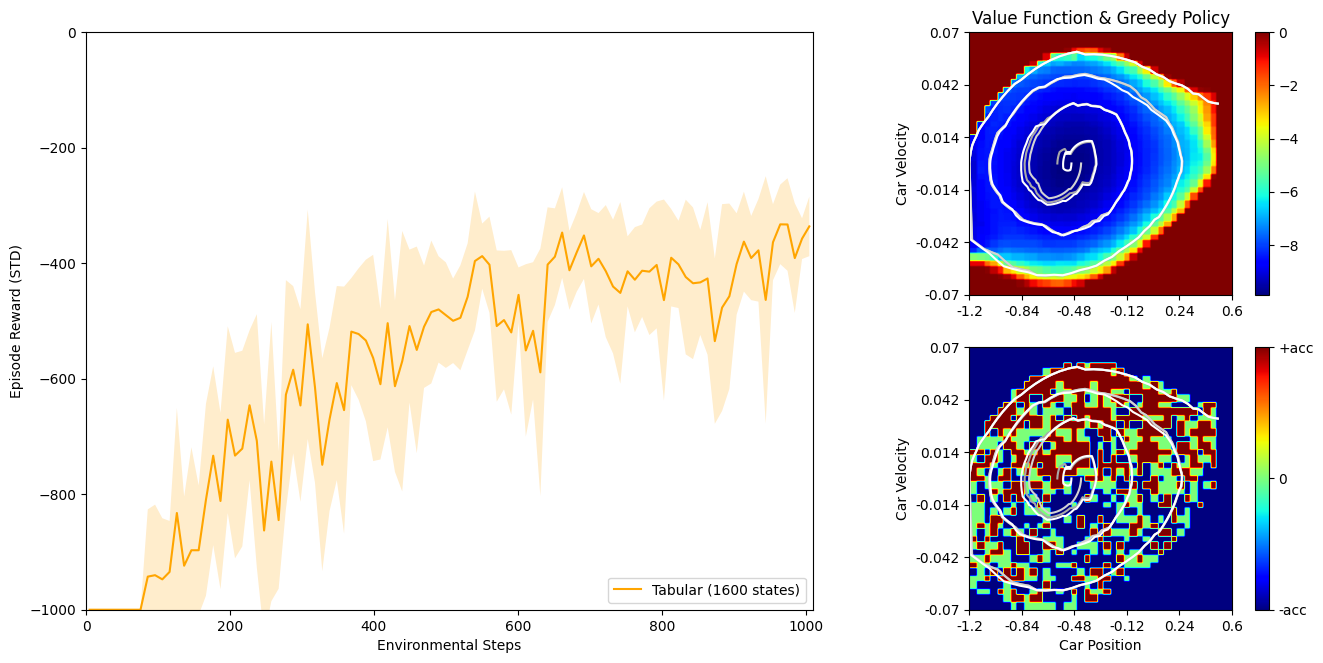

In [5]:
run_experiment(env, TabularQLearner(env, 40))
plot_all_results(env)

Discuss the resulting performance, value function and policy with your neighbours. Do you see a consistent behaviour policy, and if not, why?

The agent successfully learns to solve the MountainCar problem, achieving a significantly higher average reward by the end of training, although high performance variance suggests the policy is not perfectly stable yet. Indeed the policy appears inconsistent and "blocky" due to the discretization of the continuous state space.

# EXERCISE 2: Approximate Q-learning
In this exercise you will implement a QLearner based on gradient descend with a linear Q-value function.


## TASK 2a: basis functions
Now we want to use approximate Q-learning for linear functions. Familiarize yourself with our specification of basis functions.

In [6]:
class BasisFunctions:
    """ Abstract class that specifies basis functions. """
    name = None                  # the name of the basis function
    num_features = None          # the number of basis functions
    _env_low = None
    _env_high = None
    _env_dx = None

    def __init__(self, env):
        self._env_low = env.observation_space.low
        self._env_high = env.observation_space.high
        self._env_dx = self._env_high - self._env_low

    def __call__(self, state):
        """ Returns the basis function outputs of the given state as a vector.  """
        assert False, "Abstract class must be inherited from to call."

    def new_weights(self):
        """ Returns a newly initialized fitting weight vector. """
        return np.zeros(self.num_features)

class OneHot (BasisFunctions):
    """ one-hot encoding of 2d-spaces """
    n_states = None

    def __init__(self, env, n_states):
        """ Creates a one-hot encoding with n_states discrete intervals in each input dimension. """
        BasisFunctions.__init__(self, env)
        self.name = "OneHot"
        self.n_states = n_states
        self.num_features = n_states ** 2

    def __call__(self, state):
        """ Overrides the () operator and returns a one-hot encoding of the given state."""
        phi = np.zeros(self.num_features)
        index = np.floor((state - self._env_low) / self._env_dx * (self.n_states-1))
        phi[int(index[0] * self.n_states + index[1])] = 1
        return phi

class RBF (BasisFunctions):
    """ Exponential radial basis functions in 2d spaces."""
    normalize = True      # this flag normalizes the L_1 norm of the output vector to 1
    centers = None
    sigmas = None

    def __init__(self, env, n_bases):
        """ Creates a set of equidistant basis functions with n_bases functions in each input dimension. """
        BasisFunctions.__init__(self, env)
        self.name = "RBF"
        self.num_features = n_bases ** 2
        self._make_centers(n_bases)

    def _make_centers(self, n_bases):
        """ Initializes the centers of the RBF basis functions as an equidistant grid
            and width sigma as the distance between the centers to guarantee enough overlap. """
        # Create centers of the RBF
        self.centers = np.zeros((2, n_bases ** 2))
        self.centers[0, :] = np.repeat(np.linspace(self._env_low[0], self._env_high[0], num=n_bases), n_bases)
        self.centers[1, :] = np.tile(np.linspace(self._env_low[1], self._env_high[1], num=n_bases), n_bases)
        # Create widths of the RBF
        self.sigmas = np.zeros((2, n_bases ** 2))
        self.sigmas[0, :] = np.repeat(np.ones(n_bases) * self._env_dx[0] / (n_bases-1), n_bases)
        self.sigmas[1, :] = np.tile(np.ones(n_bases)  * self._env_dx[1] / (n_bases-1), n_bases)

    def __call__(self, state):
        """ Overrides the () operator and returns the (normalised) RBF output for the given state."""
        # Compute the RBFs
        phi = np.exp(- np.sum(((self.centers - np.expand_dims(state, axis=1)) / self.sigmas) ** 2, axis=0))
        # Optionally normalize the RBF output to sum 1
        if self.normalize:
            phi /= np.sum(phi, axis=0)
        # Return feature(s)
        return phi

## Task 2b: semi-gradients
Derive the semi-gradient of the quadratic Bellman-error of Q-learning at time $t$ (i.e. after observing s_t, a_t, r_t and s_{t+1}) for a linear Q-function. Write down both the loss function and the semi-gradient as a LaTeX formula:

The Q-value function is given by $Q(s,a) = \vec w^{a} \cdot \vec \phi(s)$.
\begin{align*}
    L_t &= \frac{1}{2}\left(r_t+\gamma \max_{a'} \vec w^{a'} \cdot \vec \phi(s_{t+1}) - \vec w^{a_{t}} \cdot \vec \phi(s_{t})\right)^2 \\[2mm]
    \frac{\partial L_t}{\partial \vec w^{a_t}} &= -\left(r_t+\gamma \max_{a'} \vec w^{a'} \cdot \vec \phi(s_{t+1}) - \vec w^{a_{t}} \cdot \vec \phi(s_{t})\right) \vec \phi(s_{t})
\end{align*}

## TASK 2c: linear Q-functions
Implement the corresponding semi-gradient QLearner in the below skeleton. Make sure that, similarly to task 1a, the end of the episode (done=True) is handled correctly.

In [7]:
class LinearQLearner (QLearner):
    learn_rate = 0.1
    basis = None
    weights = []
    env = None

    def __init__(self, env, basis: BasisFunctions):
        self.name = "Linear (%u %s)" % (basis.num_features, basis.name)
        self.basis = basis
        self.env = env
        # Initialize weights for each action
        self.weights = [basis.new_weights() for _ in range(env.action_space.n)]

    def q_values(self, state):
        """ Returns the estimated Q-values (as a np.ndarray) of the given state. """
        phi_s = self.basis(state)
        # Calculate Q-value for each action: w_a . phi(s)
        q_values_array = np.array([np.dot(self.weights[a], phi_s) for a in range(self.env.action_space.n)])
        return q_values_array

    def sample(self, state):
        """ Returns an action the agent has chosen at the given state. """
        return np.argmax(self.q_values(state))

    def update(self, state, action, reward, next_state, done):
        """ The agent 'learns' from the given transition. """
        phi_s = self.basis(state)

        # Current Q-value: Q(s, a)
        current_q = np.dot(self.weights[action], phi_s)

        # Calculate max Q-value for next_state
        if done:
            max_next_q = 0
        else:
            phi_next_s = self.basis(next_state)
            next_q_values = np.array([np.dot(self.weights[a_idx], phi_next_s) for a_idx in range(self.env.action_space.n)])
            max_next_q = np.max(next_q_values)

        # TD Target
        td_target = reward + self.gamma * max_next_q

        # TD Error
        td_error = td_target - current_q

        # Update weights for the taken action
        self.weights[action] += self.learn_rate * td_error * phi_s

## TASK 2d: approximation with one-hot bases
Test your above implementation with one-hot basis functions (with 40 bases in each state-dimension).

/Users/gorceixantoine/opt/anaconda3/envs/rl_day2/lib/python3.9/site-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


----- Start Learning with Linear (1600 OneHot) Q-learning -----
Episode #50 (50000 steps) -- Total reward = -1000, epsilon=0.1.
Episode #150 (144181 steps) -- Total reward = -1000, epsilon=0.1.
Episode #250 (220111 steps) -- Total reward = -623, epsilon=0.1.
Episode #350 (286055 steps) -- Total reward = -1000, epsilon=0.1.
Episode #450 (342787 steps) -- Total reward = -685, epsilon=0.1.
Episode #550 (390119 steps) -- Total reward = -556, epsilon=0.1.
Episode #650 (429413 steps) -- Total reward = -340, epsilon=0.1.
Episode #750 (467474 steps) -- Total reward = -599, epsilon=0.1.
Episode #850 (514211 steps) -- Total reward = -498, epsilon=0.1.
Episode #950 (558343 steps) -- Total reward = -287, epsilon=0.1.


/var/folders/yy/nk3ftmr5559gmlcky86sgvh40000gn/T/ipykernel_71173/4084323372.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["%g" % (env_low[0] + i * (env_high[0] - env_low[0]) / 5) for i in range(6)])
/var/folders/yy/nk3ftmr5559gmlcky86sgvh40000gn/T/ipykernel_71173/4084323372.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(["%g" % (env_low[1] + i * (env_high[1] - env_low[1]) / 5) for i in range(6)])
/var/folders/yy/nk3ftmr5559gmlcky86sgvh40000gn/T/ipykernel_71173/4084323372.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["%g" % (env_low[0] + i * (env_high[0] - env_low[0]) / 5) for i in range(6)])
/var/folders/yy/nk3ftmr5559gmlcky86sgvh40000gn/T/ipykernel_71173/40843

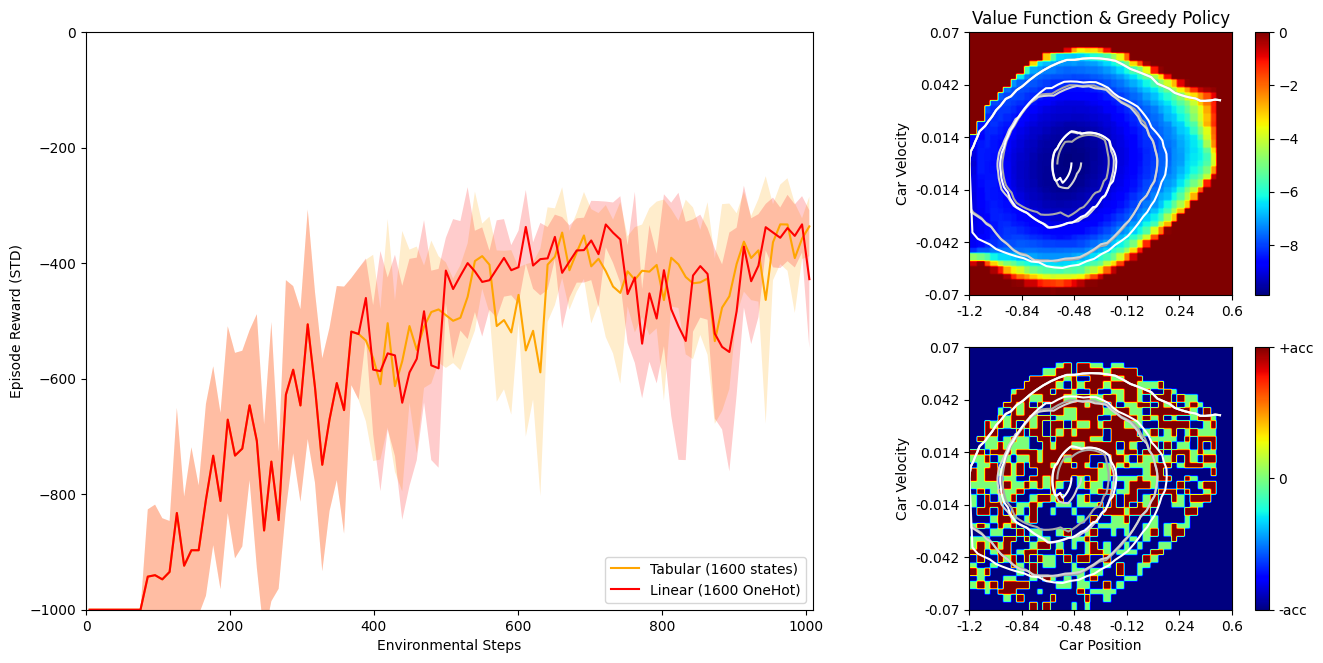

In [8]:
run_experiment(env, LinearQLearner(env, OneHot(env, 40)))
plot_all_results(env)

Can you compare your results with the TabularQLearner? What's your conclusion and why?

With one-hot features the “linear” agent behaves like a tabular agent, so the curves (left plots) sit on top of each other and the value/policy maps (right plots) look the same. Any tiny gap is just noise and step-size details—not a real performance difference.

## Task 2e: approximation with RBF bases
Now test your LinearQLearner with the given RBF bases (15 centers for each state dimension).

/Users/gorceixantoine/opt/anaconda3/envs/rl_day2/lib/python3.9/site-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


----- Start Learning with Linear (256 RBF) Q-learning -----
Episode #50 (44310 steps) -- Total reward = -593, epsilon=0.1.
Episode #150 (83322 steps) -- Total reward = -330, epsilon=0.1.
Episode #250 (106876 steps) -- Total reward = -160, epsilon=0.1.
Episode #350 (125800 steps) -- Total reward = -155, epsilon=0.1.
Episode #450 (142166 steps) -- Total reward = -162, epsilon=0.1.
Episode #550 (158920 steps) -- Total reward = -160, epsilon=0.1.
Episode #650 (175280 steps) -- Total reward = -147, epsilon=0.1.
Episode #750 (191964 steps) -- Total reward = -151, epsilon=0.1.
Episode #850 (208228 steps) -- Total reward = -155, epsilon=0.1.
Episode #950 (223930 steps) -- Total reward = -152, epsilon=0.1.


/var/folders/yy/nk3ftmr5559gmlcky86sgvh40000gn/T/ipykernel_71173/4084323372.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["%g" % (env_low[0] + i * (env_high[0] - env_low[0]) / 5) for i in range(6)])
/var/folders/yy/nk3ftmr5559gmlcky86sgvh40000gn/T/ipykernel_71173/4084323372.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(["%g" % (env_low[1] + i * (env_high[1] - env_low[1]) / 5) for i in range(6)])
/var/folders/yy/nk3ftmr5559gmlcky86sgvh40000gn/T/ipykernel_71173/4084323372.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["%g" % (env_low[0] + i * (env_high[0] - env_low[0]) / 5) for i in range(6)])
/var/folders/yy/nk3ftmr5559gmlcky86sgvh40000gn/T/ipykernel_71173/40843

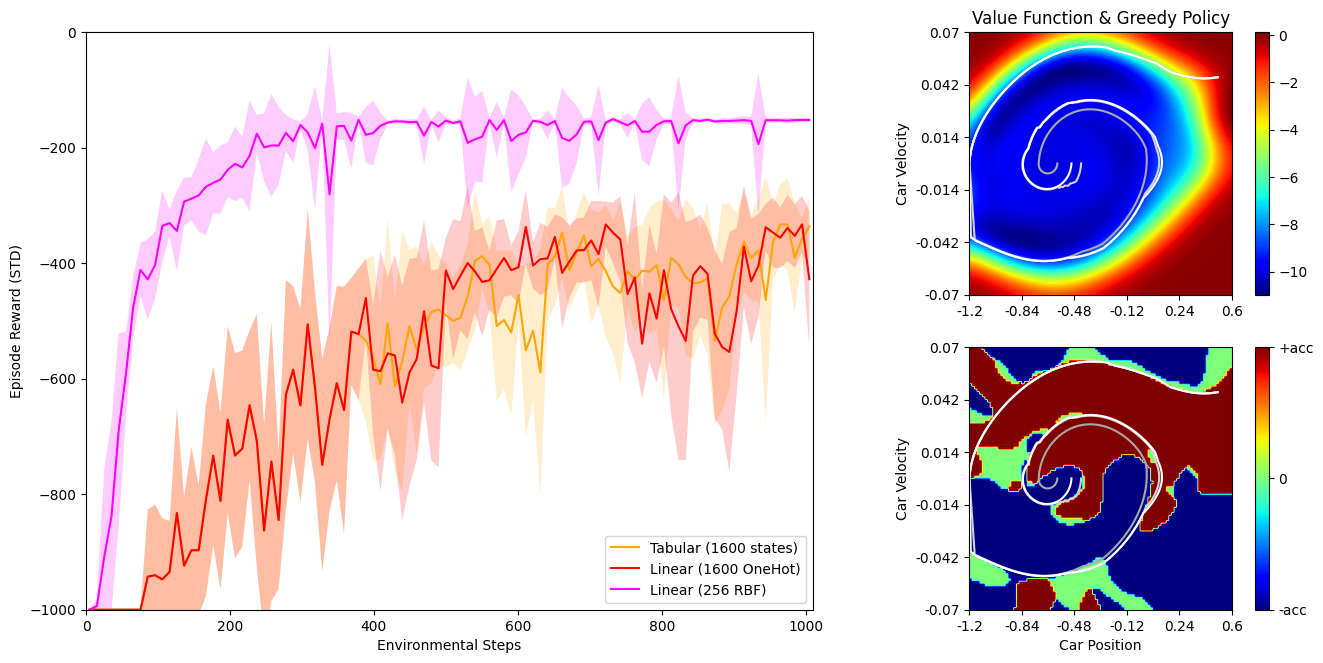

In [9]:
run_experiment(env, LinearQLearner(env, RBF(env, 16)))
plot_all_results(env)

Function approximation allows the agent to learn much faster, but the agent's performance can become extremly unstable in later episodes. This is somewhat surprising, as the lecture has established that semi-gradient TD(0) learning is supposed to converge in the linear case. Discuss with your neighbors why this is not the case here. If you want, change the number of episodes in run_experiment() to a value at which your algorithm is still stable and compare the resulting values/policies.

# EXERCISE 3: Stabilising Approximate Q-learning
Q-learning with semi-gradient descent is often unstable. In this exercise you will implement techniques that have emerged to stabilise approximate RL, namely Target Networks and Experience Replay Buffers.

## Task 3a: target networks
In this exercise you will improve the stability of gradient descend by using target networks. Note that for our purposes, the term "target network" refers to another weight vector. Extend the LinearQLearner with a target network, which is periodically updated with the current weights every 100 gradient steps.

In [10]:
class TargetQLearner(LinearQLearner):
    def __init__(self, env, basis):
        LinearQLearner.__init__(self, env, basis)
        self.name = "Target (%u %s)" % (basis.num_features, basis.name)
        # Initialize instance variables (not class variables)
        self.update_counter = 0
        self.target_update_frequency = 100
        # Deep copy of weights for target network
        self.target_weights = [np.copy(w) for w in self.weights]

    def update(self, state, action, reward, next_state, done):
        phi_s = self.basis(state)

        # Current Q-value using current weights
        current_q = np.dot(self.weights[action], phi_s)

        # Calculate max Q-value for next_state using target weights
        if done:
            max_next_q = 0
        else:
            phi_next_s = self.basis(next_state)
            next_q_values_target = np.array([np.dot(self.target_weights[a_idx], phi_next_s) 
                                            for a_idx in range(self.env.action_space.n)])
            max_next_q = np.max(next_q_values_target)

        # TD Target
        td_target = reward + self.gamma * max_next_q

        # TD Error
        td_error = td_target - current_q

        # Update weights for the taken action
        self.weights[action] += self.learn_rate * td_error * phi_s

        # Increment update counter and synchronize target network
        self.update_counter += 1
        if self.update_counter % self.target_update_frequency == 0:
            self.target_weights = [np.copy(w) for w in self.weights]

Now test your above TargetQLearner with the same 16x16 RBF bases as above.

/Users/gorceixantoine/opt/anaconda3/envs/rl_day2/lib/python3.9/site-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


----- Start Learning with Target (1024 RBF) Q-learning -----
Episode #50 (49991 steps) -- Total reward = -1000, epsilon=0.1.
Episode #150 (135472 steps) -- Total reward = -584, epsilon=0.1.
Episode #250 (192225 steps) -- Total reward = -510, epsilon=0.1.
Episode #350 (235317 steps) -- Total reward = -397, epsilon=0.1.
Episode #450 (272829 steps) -- Total reward = -279, epsilon=0.1.
Episode #550 (306774 steps) -- Total reward = -343, epsilon=0.1.
Episode #650 (338017 steps) -- Total reward = -308, epsilon=0.1.
Episode #750 (367196 steps) -- Total reward = -310, epsilon=0.1.
Episode #850 (395617 steps) -- Total reward = -235, epsilon=0.1.
Episode #950 (422417 steps) -- Total reward = -281, epsilon=0.1.


/var/folders/yy/nk3ftmr5559gmlcky86sgvh40000gn/T/ipykernel_71173/4084323372.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["%g" % (env_low[0] + i * (env_high[0] - env_low[0]) / 5) for i in range(6)])
/var/folders/yy/nk3ftmr5559gmlcky86sgvh40000gn/T/ipykernel_71173/4084323372.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(["%g" % (env_low[1] + i * (env_high[1] - env_low[1]) / 5) for i in range(6)])
/var/folders/yy/nk3ftmr5559gmlcky86sgvh40000gn/T/ipykernel_71173/4084323372.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["%g" % (env_low[0] + i * (env_high[0] - env_low[0]) / 5) for i in range(6)])
/var/folders/yy/nk3ftmr5559gmlcky86sgvh40000gn/T/ipykernel_71173/40843

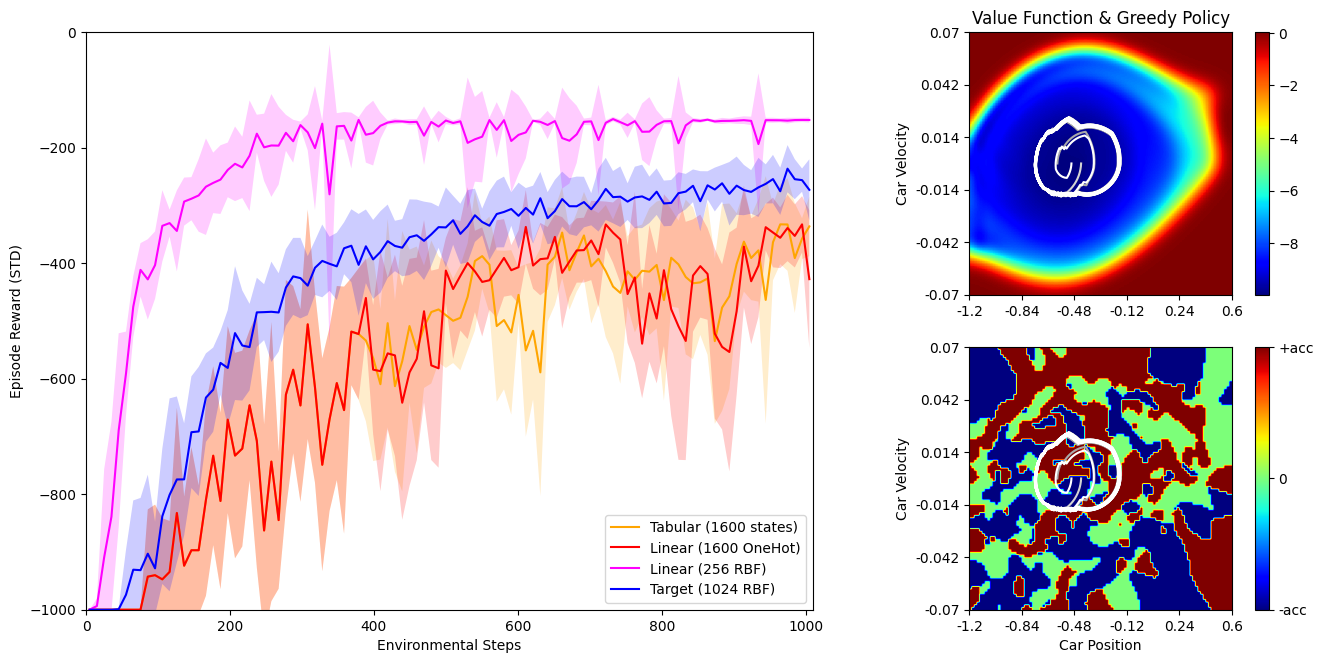

In [11]:
run_experiment(env, TargetQLearner(env, RBF(env, 32)))
plot_all_results(env)

The target networks can stabilise an agent's performance quite a bit, but do not have to. Do you observe more stable learning? Is the behaviour still unstable at the end?

Yes—learning is noticeably more stable than the plain linear case (fewer spikes and no catastrophic drops).
However, it doesn’t fully settle: the returns still wobble within a band near the end, so some instability remains.

## TASK 3b: double Q-learning
Extend the class TargetQLearner to implement double Q-learning (akin to Double DQN from the lecture). Double Q-learning determines the best action for the next state s_{t+1} using the current network, but evaluates that action on the target network, just as in TargetQLearner.

In [12]:
class DoubleQLearner(TargetQLearner):
    def __init__(self, env, basis):
        TargetQLearner.__init__(self, env, basis)
        self.name = "Double (%u %s)" % (basis.num_features, basis.name)

    def update(self, state, action, reward, next_state, done):
        phi_s = self.basis(state)

        # Current Q-value using current weights
        current_q = np.dot(self.weights[action], phi_s)

        # Double Q-learning: decouple action selection and evaluation
        if done:
            max_next_q = 0
        else:
            phi_next_s = self.basis(next_state)

            # Step 1: Select best action using CURRENT weights
            current_next_q_values = np.array([np.dot(self.weights[a_idx], phi_next_s) 
                                             for a_idx in range(self.env.action_space.n)])
            best_action = np.argmax(current_next_q_values)

            # Step 2: Evaluate selected action using TARGET weights
            max_next_q = np.dot(self.target_weights[best_action], phi_next_s)

        # TD Target
        td_target = reward + self.gamma * max_next_q

        # TD Error
        td_error = td_target - current_q

        # Update weights for the taken action
        self.weights[action] += self.learn_rate * td_error * phi_s

        # Increment counter and update target network
        self.update_counter += 1
        if self.update_counter % self.target_update_frequency == 0:
            self.target_weights = [np.copy(w) for w in self.weights]

Now test your above DoubleQLearner with the same RBF bases as above. Double Q-learning should further stabilise the agent's performance.

/Users/gorceixantoine/opt/anaconda3/envs/rl_day2/lib/python3.9/site-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


----- Start Learning with Double (1024 RBF) Q-learning -----
Episode #50 (49783 steps) -- Total reward = -1000, epsilon=0.1.
Episode #150 (136301 steps) -- Total reward = -659, epsilon=0.1.
Episode #250 (192242 steps) -- Total reward = -398, epsilon=0.1.
Episode #350 (235599 steps) -- Total reward = -331, epsilon=0.1.
Episode #450 (272680 steps) -- Total reward = -361, epsilon=0.1.
Episode #550 (306388 steps) -- Total reward = -320, epsilon=0.1.
Episode #650 (337307 steps) -- Total reward = -332, epsilon=0.1.
Episode #750 (366564 steps) -- Total reward = -326, epsilon=0.1.
Episode #850 (394837 steps) -- Total reward = -242, epsilon=0.1.
Episode #950 (421898 steps) -- Total reward = -197, epsilon=0.1.


/var/folders/yy/nk3ftmr5559gmlcky86sgvh40000gn/T/ipykernel_71173/4084323372.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["%g" % (env_low[0] + i * (env_high[0] - env_low[0]) / 5) for i in range(6)])
/var/folders/yy/nk3ftmr5559gmlcky86sgvh40000gn/T/ipykernel_71173/4084323372.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(["%g" % (env_low[1] + i * (env_high[1] - env_low[1]) / 5) for i in range(6)])
/var/folders/yy/nk3ftmr5559gmlcky86sgvh40000gn/T/ipykernel_71173/4084323372.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["%g" % (env_low[0] + i * (env_high[0] - env_low[0]) / 5) for i in range(6)])
/var/folders/yy/nk3ftmr5559gmlcky86sgvh40000gn/T/ipykernel_71173/40843

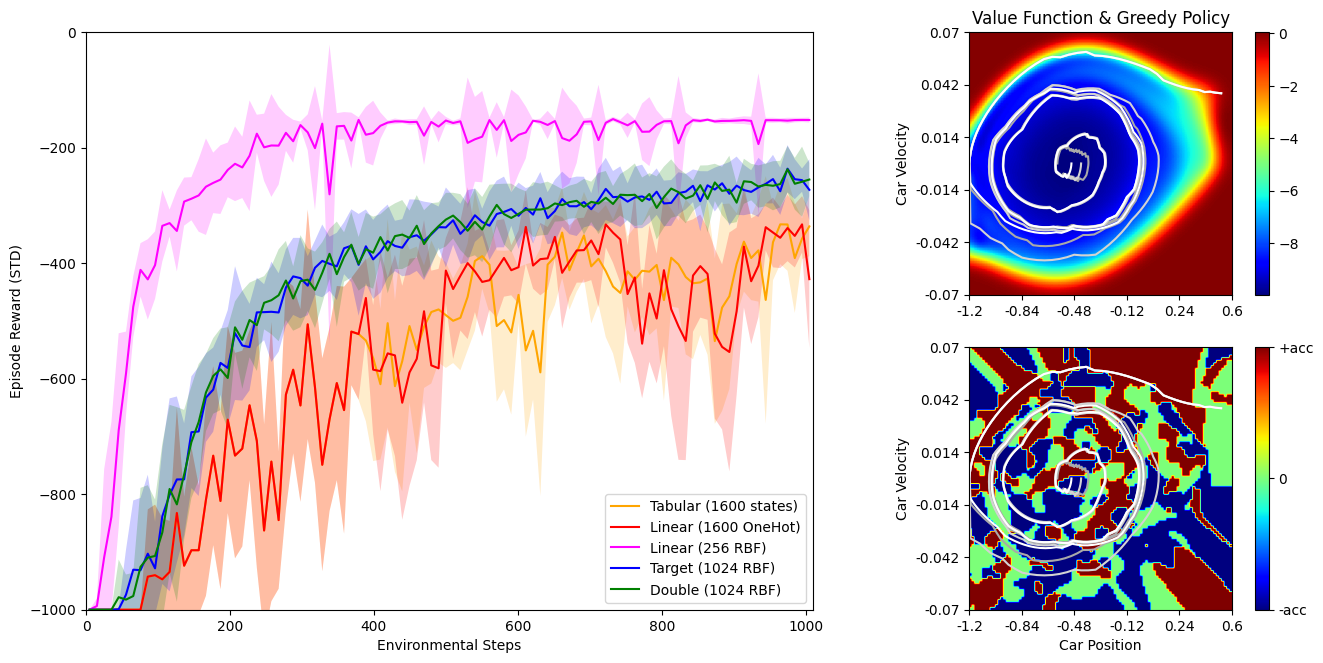

In [13]:
run_experiment(env, DoubleQLearner(env, RBF(env, 32)))
plot_all_results(env)

If you do not have a stable solution by now, increase the number of basis fuctions for each state dimension.
How does the policy look like in comparison to the tabular case in task 1c? Can you formulate an optimal policy for mountain-car based on your observations?

After increasing the number of basis functions we obtain a satisfactory curve. The policy looks much smoother with low variance compared to the tabular task 1c. We can try to formulate this optaimal policy for mountain-car based on our observations: 

$$
\textbf{Approx.\ optimal (mountain--car): }\ a^*(x,v)=\operatorname{sgn}(v)\quad
\big(\text{push left if }v<0,\ \text{right if }v>0;\ a=0\text{ rarely}\big),
\ \text{with a small hysteresis }|v|>\varepsilon\ \text{and a final right push as }x\to x_{\text{goal}}.
$$

# EXERCISE 4: Deep Q-Networks
In this exercise we will implement Q-learning with a neural network. Read the DQN paper by Mnih et al. https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf for help with the exercise.

## TASK 4a
Implement a deep Q net that holds 10,000 transitions and uses a mini-batch of 32 samples. Make sure that the mini-batch always includes the newest transition.

The following code describes a simple replay buffer which is used to store (state, action, reward, next_state, done) tuples.

In [14]:
class Replay_buffer():
    def __init__(self, capacity):
        self.buffer = []
        for i in range(capacity):
                self.buffer.append(None)
        self.capacity = capacity
        self.insert_index = 0
        self.num_exp = 0

    def push(self, sarst):
        self.buffer[self.insert_index] = sarst
        self.insert_index = (self.insert_index + 1)%self.capacity
        if self.num_exp < self.capacity:
            self.num_exp += 1

    def sample_buffer(self):
        index = random.randint(0, self.num_exp-1)
        return self.buffer[index]

    def sample_batch(self, size):
        batch = []
        for i in range(size):
            batch.append(self.sample_buffer())
        return batch

Similarly the code-let below describes simple a 3 layer neural network which outputs an action value for all the valid actions in mountaincar.

In [15]:
class Value_Net(torch.nn.Module):
    hidden = 20

    def __init__(self):
        super(Value_Net, self).__init__()
        self.fc1 = torch.nn.Linear(2, self.hidden)
        self.fc2 = torch.nn.Linear(self.hidden, self.hidden)
        self.fc3 = torch.nn.Linear(self.hidden, 3)

    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Complete the class DQLearner to implement a DQN that solves the mountain car environment.

In [16]:
class DQLearner(QLearner):
    buffer_size = 10000
    batch_size = 32
    learning_rate = 1e-3
    qnet = None
    buffer = None
    optimizer = None
    criterion = None

    def __init__(self):
        self.name = "DQN"
        self.qnet = Value_Net()
        self.buffer = Replay_buffer(self.buffer_size)
        self.optimizer = torch.optim.RMSprop(self.qnet.parameters(), lr=self.learning_rate)
        self.criterion = torch.nn.MSELoss()

    def q_values(self, state):
        return self.qnet(torch.Tensor(state))

    def sample(self, state):
        return np.argmax(self.q_values(state).detach().numpy())

    def update(self, state, action, reward, next_state, done):
        obs = {'old': state, 'action': action, 'reward': reward, 'new': next_state, 'done': done}
        self.buffer.push(obs)
        if self.buffer.num_exp < self.batch_size:
            return
        else:
            # Sample a batch of transitions (which includes the currently observed)
            batch = self.buffer.sample_batch(self.batch_size - 1)
            batch.append(obs)
            
            # Convert batch to tensors
            states = torch.Tensor([exp['old'] for exp in batch])
            actions = torch.LongTensor([exp['action'] for exp in batch])
            rewards = torch.Tensor([exp['reward'] for exp in batch])
            next_states = torch.Tensor([exp['new'] for exp in batch])
            dones = torch.Tensor([exp['done'] for exp in batch])
            
            # Compute current Q-values
            q_values = self.qnet(states)
            q_values_selected = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)
            
            # Compute target Q-values
            with torch.no_grad():
                next_q_values = self.qnet(next_states)
                max_next_q_values = next_q_values.max(1)[0]
                target_q_values = rewards + self.gamma * max_next_q_values * (1 - dones)
            
            # Compute loss
            loss = self.criterion(q_values_selected, target_q_values)
            
            # Reset the gradients to zero
            self.optimizer.zero_grad()
            
            # Backpropagate loss gradient through the network
            loss.backward()
            
            # Take a parameter update step
            self.optimizer.step()

    def set_epsilon(self, iter):
        """ Exponentially decays the eploration parameter epsilon. """
        self.epsilon = nate**(-iter/250.0)

/Users/gorceixantoine/opt/anaconda3/envs/rl_day2/lib/python3.9/site-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
/var/folders/yy/nk3ftmr5559gmlcky86sgvh40000gn/T/ipykernel_71173/2642522523.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  states = torch.Tensor([exp['old'] for exp in batch])


----- Start Learning with DQN Q-learning -----
Episode #50 (50000 steps) -- Total reward = -1000, epsilon=0.822012.
Episode #150 (149687 steps) -- Total reward = -1000, epsilon=0.551011.
Episode #250 (249687 steps) -- Total reward = -1000, epsilon=0.369354.
Episode #350 (349687 steps) -- Total reward = -1000, epsilon=0.247585.
Episode #450 (448779 steps) -- Total reward = -1000, epsilon=0.165961.
Episode #550 (548704 steps) -- Total reward = -1000, epsilon=0.111247.
Episode #650 (610530 steps) -- Total reward = -181, epsilon=0.0745713.
Episode #750 (639016 steps) -- Total reward = -490, epsilon=0.0499866.
Episode #850 (669233 steps) -- Total reward = -158, epsilon=0.033507.
Episode #950 (708922 steps) -- Total reward = -260, epsilon=0.0224604.


/var/folders/yy/nk3ftmr5559gmlcky86sgvh40000gn/T/ipykernel_71173/4084323372.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["%g" % (env_low[0] + i * (env_high[0] - env_low[0]) / 5) for i in range(6)])
/var/folders/yy/nk3ftmr5559gmlcky86sgvh40000gn/T/ipykernel_71173/4084323372.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(["%g" % (env_low[1] + i * (env_high[1] - env_low[1]) / 5) for i in range(6)])
/var/folders/yy/nk3ftmr5559gmlcky86sgvh40000gn/T/ipykernel_71173/4084323372.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["%g" % (env_low[0] + i * (env_high[0] - env_low[0]) / 5) for i in range(6)])
/var/folders/yy/nk3ftmr5559gmlcky86sgvh40000gn/T/ipykernel_71173/40843

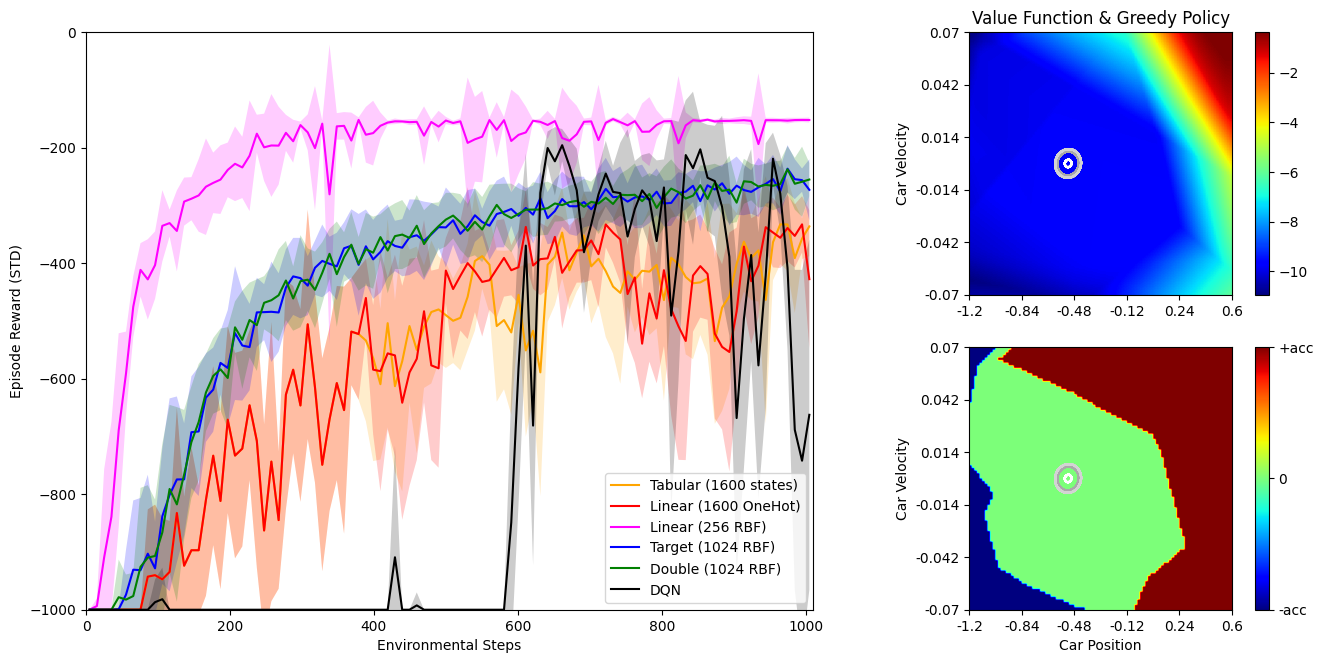

In [17]:
run_experiment(env, DQLearner())
plot_all_results(env)

## TASK 4b: DQN variations
There are several things that can be tried out with the DQN. Figure out if using different learning rates, losses and network architecture (number of layers and connectivity) changes the network performance. You can even change the replay buffer implementation to define some heuristic to draw samples from. Explore if these modifications help.

# EXERCISE 5: Improve Q-learning
If you have finished the above tasks and still have some time left, play aound with your solutions to improve performance. In particular, test the following changes for any of the above classes that inherit from LinearQLearner:

## TASK 5a: number of basis function
Plot the performance of the LinearQLearner (and it's descendants) against the number of used RBF basis functions in [10x10, ..., 20x20]. Does an increasing number of bases increase or decrease stability? Note that you need to write your own plotting script.

Ignoring the collapsed 10×10/12×12 runs, more RBF bases generally increase stability for LinearQLearner and DoubleQLearner (best at 20×20), but decrease stability for TargetQLearner beyond ~16×16—so 14–16×16 is most stable for Target, while ~20×20 is best for Linear/Double.

Testing different numbers of basis functions...

--- Testing with 10x10 RBF bases ---
----- Start Learning with Linear (100 RBF) Q-learning -----


/Users/gorceixantoine/opt/anaconda3/envs/rl_day2/lib/python3.9/site-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


Episode #50 (32427 steps) -- Total reward = -338, epsilon=0.1.
Episode #150 (77962 steps) -- Total reward = -219, epsilon=0.1.
Episode #250 (151253 steps) -- Total reward = -1000, epsilon=0.1.
Episode #350 (251253 steps) -- Total reward = -1000, epsilon=0.1.
Episode #450 (351253 steps) -- Total reward = -1000, epsilon=0.1.
Episode #550 (451253 steps) -- Total reward = -1000, epsilon=0.1.
Episode #650 (551253 steps) -- Total reward = -1000, epsilon=0.1.
Episode #750 (651253 steps) -- Total reward = -1000, epsilon=0.1.
Episode #850 (751253 steps) -- Total reward = -1000, epsilon=0.1.
Episode #950 (851253 steps) -- Total reward = -1000, epsilon=0.1.
----- Start Learning with Target (100 RBF) Q-learning -----
Episode #50 (33329 steps) -- Total reward = -418, epsilon=0.1.
Episode #150 (70703 steps) -- Total reward = -301, epsilon=0.1.
Episode #250 (92956 steps) -- Total reward = -224, epsilon=0.1.
Episode #350 (129399 steps) -- Total reward = -1000, epsilon=0.1.
Episode #450 (229399 steps) 

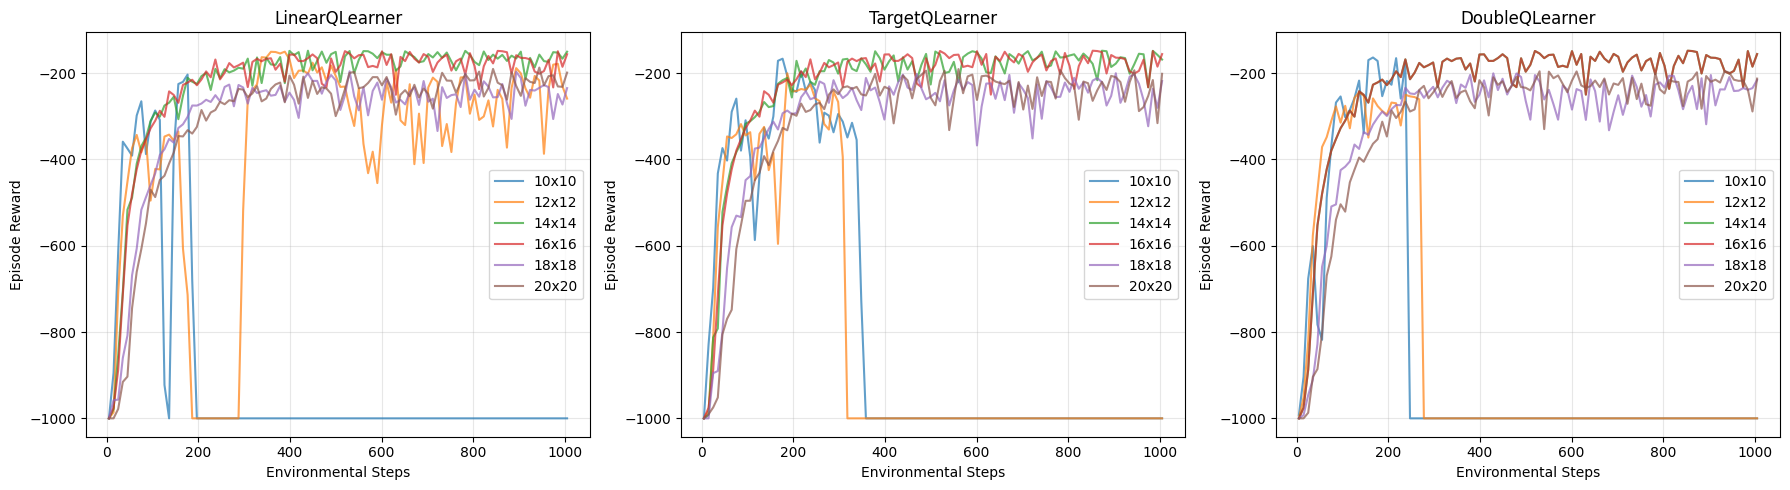


=== Stability Analysis ===

LinearQLearner:
  10x10: final reward=-1000.00, stability=0.00
  12x12: final reward=-238.67, stability=128.93
  14x14: final reward=-168.77, stability=61.65
  16x16: final reward=-181.76, stability=82.87
  18x18: final reward=-251.00, stability=118.35
  20x20: final reward=-214.21, stability=51.26

TargetQLearner:
  10x10: final reward=-1000.00, stability=0.00
  12x12: final reward=-1000.00, stability=0.00
  14x14: final reward=-173.03, stability=82.93
  16x16: final reward=-181.76, stability=82.87
  18x18: final reward=-247.21, stability=111.91
  20x20: final reward=-245.61, stability=132.41

DoubleQLearner:
  10x10: final reward=-1000.00, stability=0.00
  12x12: final reward=-1000.00, stability=0.00
  14x14: final reward=-181.76, stability=82.87
  16x16: final reward=-181.76, stability=82.87
  18x18: final reward=-236.79, stability=92.02
  20x20: final reward=-222.35, stability=57.73


In [20]:
basis_numbers = [10, 12, 14, 16, 18, 20]
results_linear = {bn: [] for bn in basis_numbers}
results_target = {bn: [] for bn in basis_numbers}
results_double = {bn: [] for bn in basis_numbers}

print("Testing different numbers of basis functions...")
for n_bases in basis_numbers:
    print(f"\n--- Testing with {n_bases}x{n_bases} RBF bases ---")
    
    # Test LinearQLearner
    agent_linear = LinearQLearner(env, RBF(env, n_bases))
    run_experiment(env, agent_linear)
    results_linear[n_bases] = plot_rewards[-1]
    
    # Test TargetQLearner
    agent_target = TargetQLearner(env, RBF(env, n_bases))
    run_experiment(env, agent_target)
    results_target[n_bases] = plot_rewards[-1]
    
    # Test DoubleQLearner
    agent_double = DoubleQLearner(env, RBF(env, n_bases))
    run_experiment(env, agent_double)
    results_double[n_bases] = plot_rewards[-1]

# Plot results
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (results, title, ax) in enumerate([
    (results_linear, 'LinearQLearner', axes[0]),
    (results_target, 'TargetQLearner', axes[1]),
    (results_double, 'DoubleQLearner', axes[2])
]):
    for bn in basis_numbers:
        rew = np.array(results[bn])
        # Aggregate rewards every 10 episodes
        rew = rew[:(len(rew) - len(rew) % 10)].reshape(int(len(results[bn]) / 10), 10)
        m = np.mean(rew, axis=1)
        s = np.std(rew, axis=1)
        x = np.linspace(5, 10 * len(m) + 5, len(m))
        ax.plot(x, m, label=f'{bn}x{bn}', alpha=0.7)
    
    ax.set_xlabel("Environmental Steps")
    ax.set_ylabel("Episode Reward")
    ax.set_title(title)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Stability analysis
print("\n=== Stability Analysis ===")
for results, agent_type in [(results_linear, "Linear"), (results_target, "Target"), (results_double, "Double")]:
    print(f"\n{agent_type}QLearner:")
    for bn in basis_numbers:
        rew = np.array(results[bn])
        final_reward = np.mean(rew[-100:])
        stability = np.std(rew[-100:])
        print(f"  {bn}x{bn}: final reward={final_reward:.2f}, stability={stability:.2f}")

## TASK 5b: learning rate
Change the implementation of LinearQLearner (and it's descendants) to decrease the learning rate slowly. How does this change affect learning rate and stability?

Decaying the step size (e.g., $\alpha_t=\alpha_0/(1+t/k)$ with a small floor) makes updates **smaller over time**.

Early learning stays fast, but later updates are gentler, which reduces **variance and oscillations** in $Q$-values and improves **stability** (especially with function approximation).

If you decay too quickly, learning can stall early and converge to a slightly worse policy; a slow decay + floor **balances sample-efficiency and stability**.

=== Learning Rate Decay Comparison ===

Test without learning rate decay:
----- Start Learning with Linear (256 RBF) Q-learning -----
Episode #50 (44310 steps) -- Total reward = -593, epsilon=0.1.
Episode #150 (83322 steps) -- Total reward = -330, epsilon=0.1.
Episode #250 (106876 steps) -- Total reward = -160, epsilon=0.1.
Episode #350 (125800 steps) -- Total reward = -155, epsilon=0.1.
Episode #450 (142166 steps) -- Total reward = -162, epsilon=0.1.
Episode #550 (158920 steps) -- Total reward = -160, epsilon=0.1.
Episode #650 (175280 steps) -- Total reward = -147, epsilon=0.1.
Episode #750 (191964 steps) -- Total reward = -151, epsilon=0.1.
Episode #850 (208228 steps) -- Total reward = -155, epsilon=0.1.
Episode #950 (223930 steps) -- Total reward = -152, epsilon=0.1.
----- Start Learning with Target (256 RBF) Q-learning -----
Episode #50 (43692 steps) -- Total reward = -659, epsilon=0.1.
Episode #150 (84470 steps) -- Total reward = -347, epsilon=0.1.
Episode #250 (111581 steps) -- T

/var/folders/yy/nk3ftmr5559gmlcky86sgvh40000gn/T/ipykernel_91043/2426325174.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["%g" % (env_low[0] + i * (env_high[0] - env_low[0]) / 5) for i in range(6)])
/var/folders/yy/nk3ftmr5559gmlcky86sgvh40000gn/T/ipykernel_91043/2426325174.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(["%g" % (env_low[1] + i * (env_high[1] - env_low[1]) / 5) for i in range(6)])
/var/folders/yy/nk3ftmr5559gmlcky86sgvh40000gn/T/ipykernel_91043/2426325174.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["%g" % (env_low[0] + i * (env_high[0] - env_low[0]) / 5) for i in range(6)])
/var/folders/yy/nk3ftmr5559gmlcky86sgvh40000gn/T/ipykernel_91043/24263

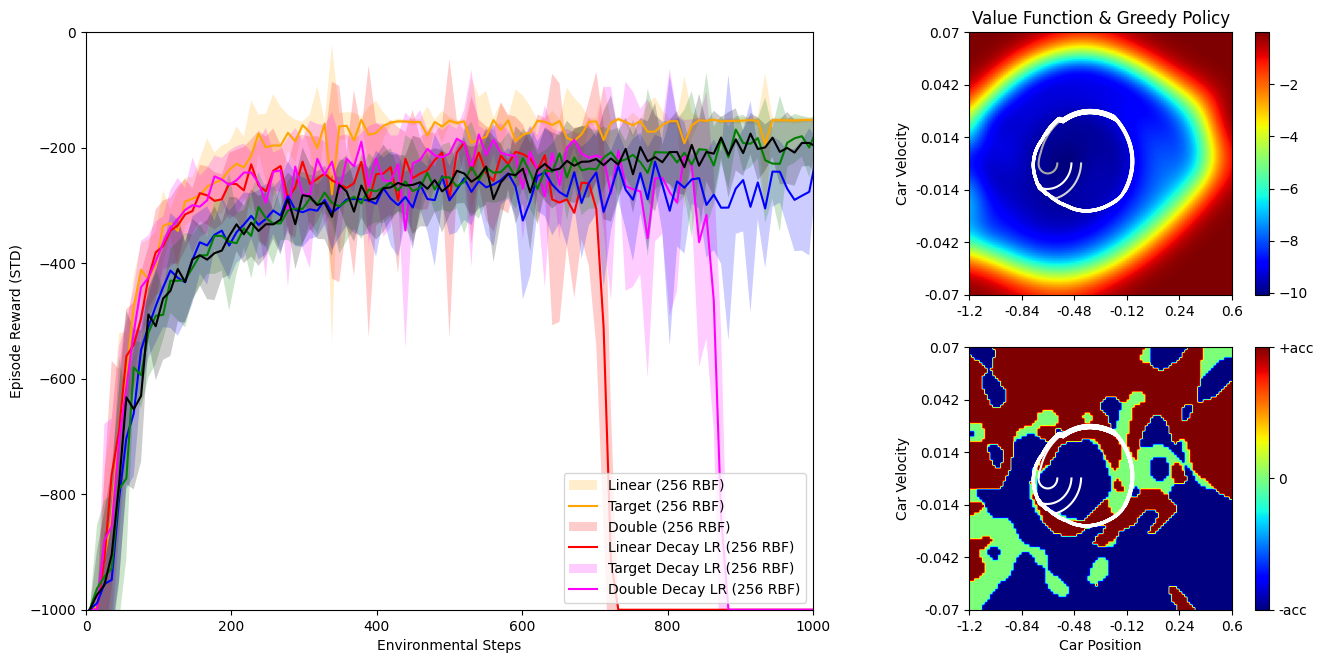

In [21]:
class LinearQLearnerDecayLR(LinearQLearner):
    """Linear Q-learner with decaying learning rate"""
    initial_lr = 0.1
    
    def __init__(self, env, basis):
        LinearQLearner.__init__(self, env, basis)
        self.name = "Linear Decay LR (%u %s)" % (basis.num_features, basis.name)
        self.update_step = 0
    
    def set_epsilon(self, iter):
        # Decay learning rate inversely proportional to iteration number
        self.learn_rate = self.initial_lr / (1 + iter / 100.0)

class TargetQLearnerDecayLR(TargetQLearner):
    """Target Q-learner with decaying learning rate"""
    initial_lr = 0.1
    
    def __init__(self, env, basis):
        TargetQLearner.__init__(self, env, basis)
        self.name = "Target Decay LR (%u %s)" % (basis.num_features, basis.name)
    
    def set_epsilon(self, iter):
        # Decay learning rate inversely proportional to iteration number
        self.learn_rate = self.initial_lr / (1 + iter / 100.0)

class DoubleQLearnerDecayLR(DoubleQLearner):
    """Double Q-learner with decaying learning rate"""
    initial_lr = 0.1
    
    def __init__(self, env, basis):
        DoubleQLearner.__init__(self, env, basis)
        self.name = "Double Decay LR (%u %s)" % (basis.num_features, basis.name)
    
    def set_epsilon(self, iter):
        # Decay learning rate inversely proportional to iteration number
        self.learn_rate = self.initial_lr / (1 + iter / 100.0)

# Comparison with and without learning rate decay
clear_plots()

print("=== Learning Rate Decay Comparison ===\n")

# Agents without decay
print("Test without learning rate decay:")
run_experiment(env, LinearQLearner(env, RBF(env, 16)))
run_experiment(env, TargetQLearner(env, RBF(env, 16)))
run_experiment(env, DoubleQLearner(env, RBF(env, 16)))

# Agents with decay
print("\nTest with learning rate decay:")
run_experiment(env, LinearQLearnerDecayLR(env, RBF(env, 16)))
run_experiment(env, TargetQLearnerDecayLR(env, RBF(env, 16)))
run_experiment(env, DoubleQLearnerDecayLR(env, RBF(env, 16)))

plot_all_results(env)

## TASK 5c: exploration
The experiment defined in task 1b uses epsilon-greedy exploration with a constant epsilon=0.1. Override the set_epsilon method of (a subclass of) LinearQLearner to implement a decay shedule, which decreases epsilon linearly from 1 to 0.01 in {10, 50, 100, 500} epsiodes. Does this improve the performance or not? What happens with an exponential decay schedule as in DQLearner?

No—decay schedules here do not improve final performance over constant ε=0.1. A short linear decay (~100 episodes) can give slightly better early rewards, but longer linear or exponential decays hurt and often collapse to −1000 in later episodes.

=== Exploration Schedule Comparison ===

Double QLearner with linear decay (100 episodes):
----- Start Learning with Double Linear Decay 100ep (256 RBF) Q-learning -----


/Users/gorceixantoine/opt/anaconda3/envs/rl_day2/lib/python3.9/site-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


Episode #50 (43830 steps) -- Total reward = -493, epsilon=0.51.
Episode #150 (84652 steps) -- Total reward = -242, epsilon=0.01.
Episode #250 (108490 steps) -- Total reward = -153, epsilon=0.01.
Episode #350 (126516 steps) -- Total reward = -168, epsilon=0.01.
Episode #450 (143492 steps) -- Total reward = -237, epsilon=0.01.
Episode #550 (167932 steps) -- Total reward = -154, epsilon=0.01.
Episode #650 (183042 steps) -- Total reward = -142, epsilon=0.01.
Episode #750 (201497 steps) -- Total reward = -217, epsilon=0.01.
Episode #850 (223077 steps) -- Total reward = -293, epsilon=0.01.
Episode #950 (245422 steps) -- Total reward = -225, epsilon=0.01.

Double QLearner with linear decay (500 episodes):
----- Start Learning with Double Linear Decay 500ep (256 RBF) Q-learning -----
Episode #50 (49874 steps) -- Total reward = -1000, epsilon=0.902.
Episode #150 (120747 steps) -- Total reward = -387, epsilon=0.702.
Episode #250 (199934 steps) -- Total reward = -1000, epsilon=0.502.
Episode #350

/var/folders/yy/nk3ftmr5559gmlcky86sgvh40000gn/T/ipykernel_91043/2426325174.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["%g" % (env_low[0] + i * (env_high[0] - env_low[0]) / 5) for i in range(6)])
/var/folders/yy/nk3ftmr5559gmlcky86sgvh40000gn/T/ipykernel_91043/2426325174.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(["%g" % (env_low[1] + i * (env_high[1] - env_low[1]) / 5) for i in range(6)])
/var/folders/yy/nk3ftmr5559gmlcky86sgvh40000gn/T/ipykernel_91043/2426325174.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["%g" % (env_low[0] + i * (env_high[0] - env_low[0]) / 5) for i in range(6)])
/var/folders/yy/nk3ftmr5559gmlcky86sgvh40000gn/T/ipykernel_91043/24263

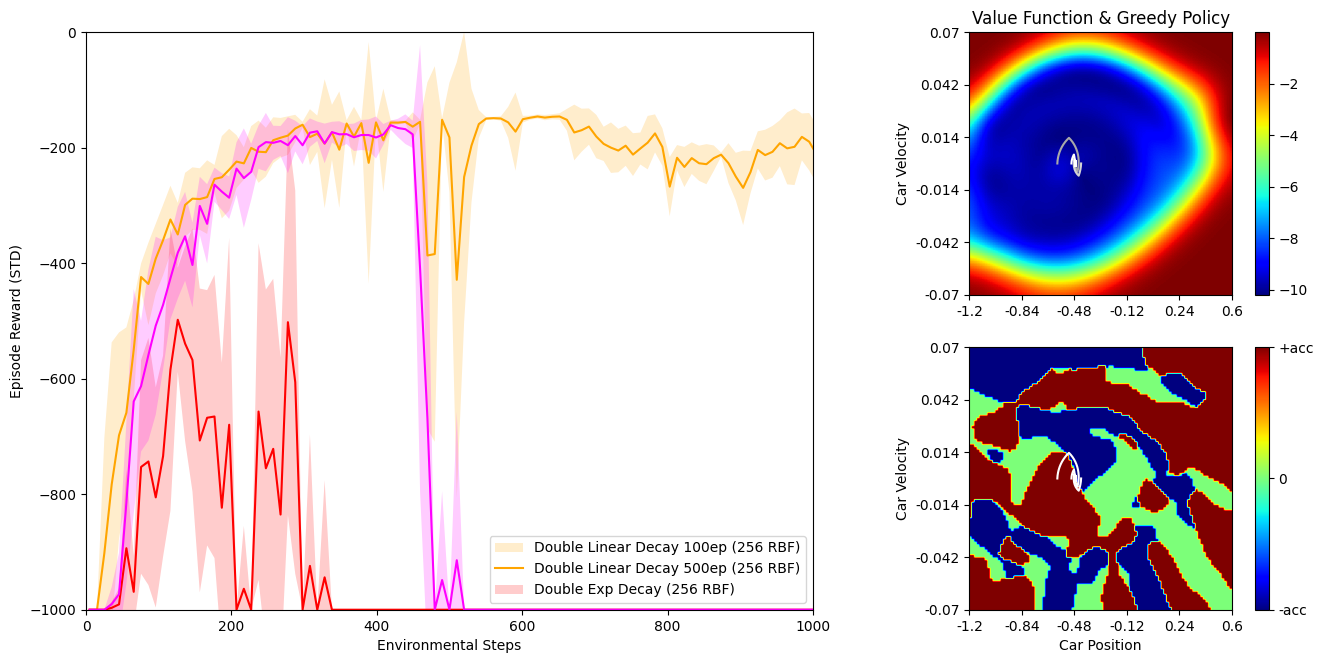

In [22]:
class LinearQLearnerLinearDecay(LinearQLearner):
    """Linear Q-learner with linear epsilon decay"""
    def __init__(self, env, basis, decay_episodes=100):
        LinearQLearner.__init__(self, env, basis)
        self.name = f"Linear Linear Decay {decay_episodes}ep (%u %s)" % (basis.num_features, basis.name)
        self.decay_episodes = decay_episodes
    
    def set_epsilon(self, iter):
        # Linear decay from 1.0 to 0.01 over decay_episodes
        self.epsilon = max(0.01, 1.0 - (iter / self.decay_episodes))

class LinearQLearnerExpDecay(LinearQLearner):
    """Linear Q-learner with exponential epsilon decay"""
    def __init__(self, env, basis):
        LinearQLearner.__init__(self, env, basis)
        self.name = "Linear Exp Decay (%u %s)" % (basis.num_features, basis.name)
    
    def set_epsilon(self, iter):
        # Exponential decay (same as DQLearner)
        self.epsilon = nate**(-iter/250.0)

class DoubleQLearnerLinearDecay(DoubleQLearner):
    """Double Q-learner with linear epsilon decay"""
    def __init__(self, env, basis, decay_episodes=100):
        DoubleQLearner.__init__(self, env, basis)
        self.name = f"Double Linear Decay {decay_episodes}ep (%u %s)" % (basis.num_features, basis.name)
        self.decay_episodes = decay_episodes
    
    def set_epsilon(self, iter):
        self.epsilon = max(0.01, 1.0 - (iter / self.decay_episodes))

class DoubleQLearnerExpDecay(DoubleQLearner):
    """Double Q-learner with exponential epsilon decay"""
    def __init__(self, env, basis):
        DoubleQLearner.__init__(self, env, basis)
        self.name = "Double Exp Decay (%u %s)" % (basis.num_features, basis.name)
    
    def set_epsilon(self, iter):
        self.epsilon = nate**(-iter/250.0)

# Test different exploration schedules
clear_plots()

print("=== Exploration Schedule Comparison ===\n")

# Linear decay: 100 episodes
print("Double QLearner with linear decay (100 episodes):")
run_experiment(env, DoubleQLearnerLinearDecay(env, RBF(env, 16), decay_episodes=100))

# Linear decay: 500 episodes
print("\nDouble QLearner with linear decay (500 episodes):")
run_experiment(env, DoubleQLearnerLinearDecay(env, RBF(env, 16), decay_episodes=500))

# Exponential decay
print("\nDouble QLearner with exponential decay:")
run_experiment(env, DoubleQLearnerExpDecay(env, RBF(env, 16)))

plot_all_results(env)

## TASK 5e: scientific evaluation
The experiment defined in task 1b fixes the random seed to ensure reproducability of results. However, each algorithm can behave very different depending on the seed. Run one (or all) above experiment(s) with 10 random seeds (i.e. comment out the lines that set the seed to 0) and plot the mean and staqndard deviation of the received rewards. Note that you may want to write your own plotting script, in which the shaded area refers to another type of standard deviation (between seeds, not over time) than in the given script.

=== Evaluation with 10 Different Random Seeds ===


--- Seed 0 ---
----- Start Learning with Linear (256 RBF) Q-learning -----


/Users/gorceixantoine/opt/anaconda3/envs/rl_day2/lib/python3.9/site-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


Episode #50 (44310 steps) -- Total reward = -593, epsilon=0.1.
Episode #150 (83322 steps) -- Total reward = -330, epsilon=0.1.
Episode #250 (106876 steps) -- Total reward = -160, epsilon=0.1.
Episode #350 (125800 steps) -- Total reward = -155, epsilon=0.1.
Episode #450 (142166 steps) -- Total reward = -162, epsilon=0.1.
Episode #550 (158920 steps) -- Total reward = -160, epsilon=0.1.
Episode #650 (175280 steps) -- Total reward = -147, epsilon=0.1.
Episode #750 (191964 steps) -- Total reward = -151, epsilon=0.1.
Episode #850 (208228 steps) -- Total reward = -155, epsilon=0.1.
Episode #950 (223930 steps) -- Total reward = -152, epsilon=0.1.
----- Start Learning with Target (256 RBF) Q-learning -----
Episode #50 (44179 steps) -- Total reward = -626, epsilon=0.1.
Episode #150 (84159 steps) -- Total reward = -360, epsilon=0.1.
Episode #250 (110742 steps) -- Total reward = -199, epsilon=0.1.
Episode #350 (135757 steps) -- Total reward = -244, epsilon=0.1.
Episode #450 (167302 steps) -- Total

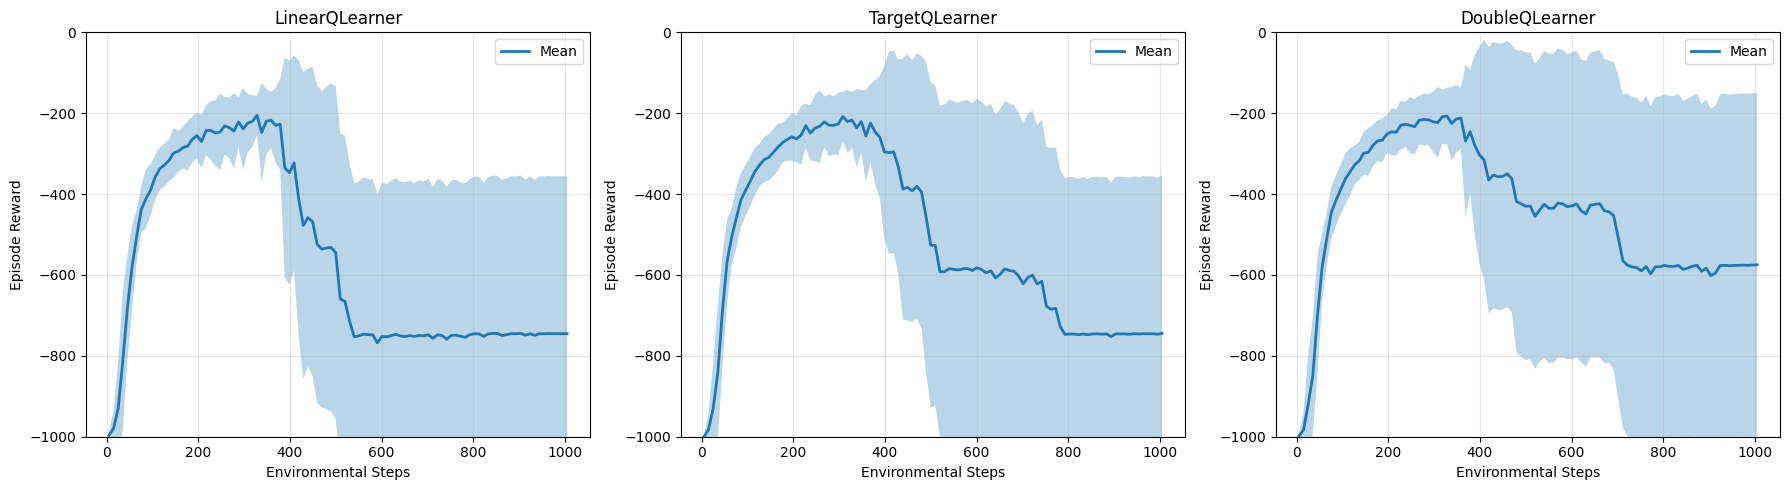


=== Final Statistics (Last 100 Episodes) ===

LinearQLearner:
  Mean: -746.03
  Standard Deviation: 388.36
  Min: -1000.00
  Max: -134.00

TargetQLearner:
  Mean: -745.66
  Standard Deviation: 388.57
  Min: -1000.00
  Max: -139.00

DoubleQLearner:
  Mean: -578.02
  Standard Deviation: 423.23
  Min: -1000.00
  Max: -94.00



In [23]:
def run_experiment_no_seed(env, agent: QLearner):
    """Run experiment without setting seed for robustness evaluation"""
    iter_max = 1000
    total_reward_list = []
    total_steps = 0
    print('----- Start Learning with %s Q-learning -----' % agent.name)
    
    for iter in range(iter_max):
        state = env.reset()
        total_reward = 0
        done = False
        
        while not done:
            current_state = state
            if np.random.uniform(0, 1) < agent.get_epsilon():
                # Random action selection
                action = np.random.choice(env.action_space.n)
            else:
                # Greedy action selection
                action = agent.sample(current_state)
            
            state, reward, done, _ = env.step(action)
            total_reward += reward
            agent.update(current_state, action, reward, state, done)
            total_steps += 1
        
        agent.set_epsilon(iter)
        total_reward_list.append(total_reward)
        
        if iter % 100 == 49:
            print('Episode #%d (%u steps) -- Total reward = %g, epsilon=%g.' %
                  (iter+1, total_steps, total_reward, agent.get_epsilon()))
    
    return total_reward_list

# Run experiments with 10 different random seeds
num_seeds = 10
agents_to_test = [
    ('LinearQLearner', lambda: LinearQLearner(env, RBF(env, 16))),
    ('TargetQLearner', lambda: TargetQLearner(env, RBF(env, 16))),
    ('DoubleQLearner', lambda: DoubleQLearner(env, RBF(env, 16))),
]

results_by_seed = {name: [] for name, _ in agents_to_test}

print("=== Evaluation with 10 Different Random Seeds ===\n")

for seed in range(num_seeds):
    print(f"\n--- Seed {seed} ---")
    
    # Do not fix seeds to get varied results
    env.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    for agent_name, agent_factory in agents_to_test:
        agent = agent_factory()
        rewards = run_experiment_no_seed(env, agent)
        results_by_seed[agent_name].append(rewards)

# Compute statistics
fig, axes = plt.subplots(1, len(agents_to_test), figsize=(18, 5))

for idx, (agent_name, _) in enumerate(agents_to_test):
    # Shape: (num_seeds, num_episodes)
    all_rewards = np.array(results_by_seed[agent_name])
    
    # Compute mean and std per episode across all seeds
    mean_rewards = np.mean(all_rewards, axis=0)
    std_rewards = np.std(all_rewards, axis=0)
    
    # Aggregate by 10 episodes (as in plot_all_results)
    mean_rewards = mean_rewards[:(len(mean_rewards) - len(mean_rewards) % 10)].reshape(
        int(len(mean_rewards) / 10), 10)
    std_rewards = std_rewards[:(len(std_rewards) - len(std_rewards) % 10)].reshape(
        int(len(std_rewards) / 10), 10)
    
    # Compute mean and std of the aggregated values
    m = np.mean(mean_rewards, axis=1)
    s = np.mean(std_rewards, axis=1)  # Standard deviation across episodes
    
    x = np.linspace(5, 10 * len(m) + 5, len(m))
    
    # Plot with shaded region representing uncertainty
    axes[idx].fill_between(x=x, y1=m - s, y2=m + s, alpha=0.3, linewidth=0)
    axes[idx].plot(x, m, linewidth=2, label='Mean')
    axes[idx].set_xlabel("Environmental Steps")
    axes[idx].set_ylabel("Episode Reward")
    axes[idx].set_title(agent_name)
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_ylim(-1000, 0)
    axes[idx].legend()

plt.tight_layout()
plt.show()

# Final statistics
print("\n=== Final Statistics (Last 100 Episodes) ===\n")
for agent_name in [name for name, _ in agents_to_test]:
    all_rewards = np.array(results_by_seed[agent_name])
    # Shape: (num_seeds, 100)
    final_100 = all_rewards[:, -100:]
    
    mean_final = np.mean(final_100)
    std_final = np.std(final_100)
    
    print(f"{agent_name}:")
    print(f"  Mean: {mean_final:.2f}")
    print(f"  Standard Deviation: {std_final:.2f}")
    print(f"  Min: {np.min(final_100):.2f}")
    print(f"  Max: {np.max(final_100):.2f}\n")